# Predicción de categoria de productos

### Links

- [Text Classification with BERT in PyTorch](https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f)
- [Best models](https://huggingface.co/models)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../src')

from matplotlib import pyplot as plt
import seaborn as sns

import numpy  as np
import pandas as pd
import torch
from   torch import nn
from   torch.optim import Adam
    
import logging
import random

import data  as dt
import model as ml
import util  as ut
import pytorch_common.util as pu

## Setup

Se configura el default logger para que la consola sea el output y loguee mensajes a partir del nivel INFO.

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

Por defecto usamos GPU. De no existir este hardware, el fallback es CPU:

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.__version__

'1.12.1+cu116'

In [6]:
pu.set_device_name('gpu')

logging.info(pu.get_device())

2022-09-18 19:34:27,538 - INFO - cuda:0


In [7]:
torch.cuda.get_arch_list()

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']

Fijamos la semilla:

In [8]:
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)

In [9]:
set_seed(42)

Parametros de la notebook:

In [10]:
DATASET_PATH       = '../../datasets/fashion-outfits'
WEIGHTS_PATH       = '../../weights'
MODEL_WEIGHTS_PATH = f'{WEIGHTS_PATH}/model_weights.h5'

!mkdir -p {WEIGHTS_PATH}

Modelo pre entrenado a utilizar. Este es una capa/module mas de nuestro modelo:

In [11]:
BERT_MODEL ='bert-base-cased'
# BERT_MODEL ='distilbert-base-cased'
# BERT_MODEL ='distilbert-base-uncased'
# BERT_MODEL ='albert-base-v2'

## Cargar dataset

In [12]:
train_set = pd.read_csv(f'{DATASET_PATH}/train.csv')
val_set   = pd.read_csv(f'{DATASET_PATH}/val.csv')
test_set  = pd.read_csv(f'{DATASET_PATH}/test.csv')

In [13]:
train_set.head()

,id,family,category,sub_category,description,highlights,brand,gender,materials,branch,branch_seq
0,16946757,clothing,trousers,track pants,pinstripe-print track pants,"[pale grey, cotton-cashmere blend, fine knit, ...",eleventy,men,['Cotton' 'Cashmere'],clothing~trousers~track pants,27
1,17335981,clothing,jackets,blazers,Luka belted blazer,"[anthracite grey, wool-blend, notched lapels, ...",tibi,women,['Spandex/Elastane' 'Polyester' 'Wool'],clothing~jackets~blazers,137
2,17226286,clothing,jackets,padded & down jackets,double-breasted padded coat,"[light grey , feather down , padded design, cl...",kired,men,['Feather Down' 'Polyamide'],clothing~jackets~padded & down jackets,41
3,17963556,clothing,knitwear,jumpers,Juliet sleeves crew neck jumper,"[red, knitted construction, Juliet sleeves, cr...",stella mccartney,women,['Polyester' 'Sustainable Viscose'],clothing~knitwear~jumpers,25
4,16843596,clothing,trousers,track pants,dart-detail elastic waist trousers,"[black, cotton-blend, dart detailing, elastica...",vetements (vip),women,['Cotton' 'Polyester'],clothing~trousers~track pants,27


In [14]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640 entries, 0 to 8639
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            8640 non-null   int64 
 1   family        8640 non-null   object
 2   category      8640 non-null   object
 3   sub_category  8640 non-null   object
 4   description   8640 non-null   object
 5   highlights    8352 non-null   object
 6   brand         8640 non-null   object
 7   gender        8640 non-null   object
 8   materials     8635 non-null   object
 9   branch        8640 non-null   object
 10  branch_seq    8640 non-null   int64 
dtypes: int64(2), object(9)
memory usage: 742.6+ KB


In [15]:
train_set['description'] = train_set['description'].apply(str)
val_set['description']   = val_set['description'].apply(str)
test_set['description']  = test_set['description'].apply(str)

Tamaño máximo de la secuencia de entrada:

In [16]:
max_length = 2 + train_set['description'].apply(len).max()
max_length

97

In [17]:
tokenizer = ml.Tokenizer(
    BERT_MODEL,
    padding    = 'max_length',
    max_length = max_length
)

In [18]:
train_dataset = dt.BertDataset(
    train_set,
    feature_col = 'description', 
    target_col  = 'branch_seq',
    tokenizer   = tokenizer
)

val_dataset = dt.BertDataset(
    val_set,
    feature_col = 'description', 
    target_col  = 'branch_seq',
    tokenizer   = tokenizer
)

test_dataset = dt.BertDataset(
    test_set,
    feature_col = 'description', 
    target_col  = 'branch_seq',
    tokenizer   = tokenizer
)

Cantidad de clases a predecir:

In [48]:
n_classes = train_set['branch_seq'].unique()
n_classes, n_classes.shape 

(
    array([ 27, 137,  41,  25,  46,   2, 212, 253,   5,   6,  87,  97, 172,
        80,  24, 112, 140, 167, 125,  28, 249,  98,  60, 181, 186,  57,
        17,  72,  26,  91,  40, 218, 215, 110,  39, 252, 210, 102, 251,
       244,  45, 162, 221, 191,  73, 105,  36, 114]),
    (48,)
)

In [20]:
classifier = ml.BertClassifier(
    output_dim = n_classes,
    model      = BERT_MODEL,
    dropout    = 0.1
)

## Entrenamiento y evaluación

In [21]:
# classifier.load(MODEL_WEIGHTS_PATH)

In [22]:
model = ml.BertModel(
    classifier,
    batch_size = 70,
    criterion  = nn.CrossEntropyLoss()
)

In [33]:
model.fit(
    train_dataset, 
    val_dataset = val_dataset,
    optimizer   = Adam(classifier.parameters(), lr = 0.00001),
    epochs      = 10
)

2022-09-18 19:50:31,590 - INFO - Time: 0:00:34.58 | Epoch: 1 | Train(loss: 0.003948, acc: 91.27%) | Val(loss: 0.013708, acc: 73.33%) | acc diff: 17.94%
2022-09-18 19:51:06,386 - INFO - Time: 0:00:34.80 | Epoch: 2 | Train(loss: 0.003681, acc: 91.61%) | Val(loss: 0.013924, acc: 73.12%) | acc diff: 18.48%
2022-09-18 19:51:41,275 - INFO - Time: 0:00:34.89 | Epoch: 3 | Train(loss: 0.003573, acc: 91.68%) | Val(loss: 0.013805, acc: 72.50%) | acc diff: 19.18%
2022-09-18 19:52:16,142 - INFO - Time: 0:00:34.87 | Epoch: 4 | Train(loss: 0.003291, acc: 92.82%) | Val(loss: 0.014746, acc: 73.33%) | acc diff: 19.49%
2022-09-18 19:52:51,014 - INFO - Time: 0:00:34.87 | Epoch: 5 | Train(loss: 0.003145, acc: 92.85%) | Val(loss: 0.015017, acc: 74.17%) | acc diff: 18.68%
2022-09-18 19:53:26,817 - INFO - Time: 0:00:35.80 | Epoch: 6 | Train(loss: 0.003063, acc: 92.97%) | Val(loss: 0.014965, acc: 72.29%) | acc diff: 20.68%
2022-09-18 19:54:03,325 - INFO - Time: 0:00:36.51 | Epoch: 7 | Train(loss: 0.002991, acc

{'loss': 0.002589251849955569, 'acc': 0.9393518518518519}

In [37]:
classifier.save(MODEL_WEIGHTS_PATH)

In [38]:
summary = model.validate(test_dataset)

In [39]:
summary.accuracy, summary.loss

(0.75625, 0.013295155018568039)

In [49]:
# summary.targets

In [50]:
# summary.predictions

In [42]:
np.concatenate(summary.predictions).shape

(480,)

<Figure size 1200x1200 with 2 Axes>

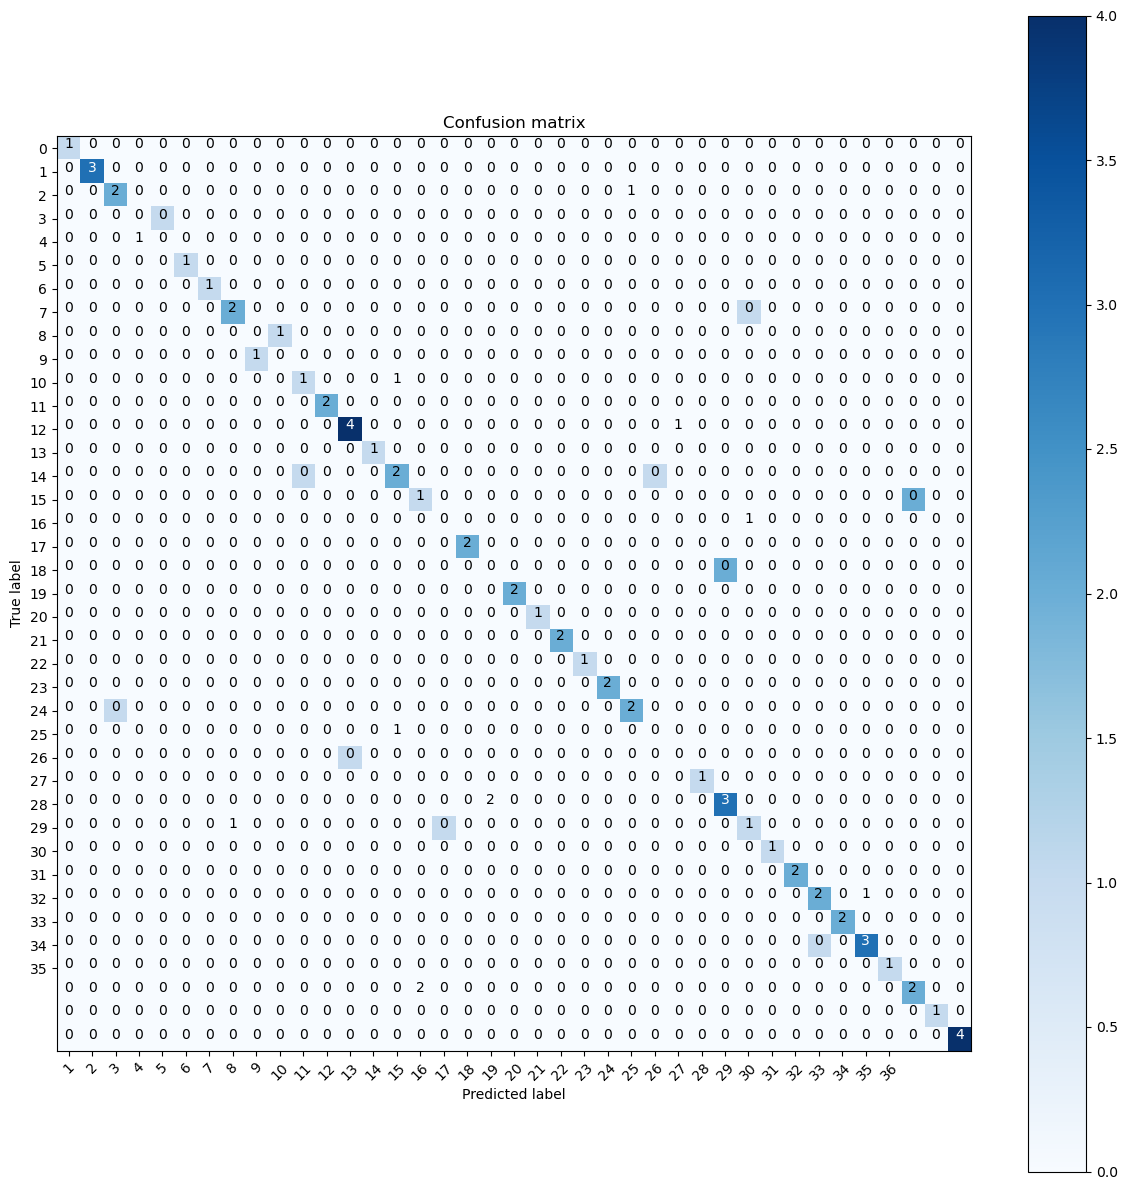

              precision    recall  f1-score   support

           2       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         3
          17       0.67      1.00      0.80         2
          24       0.00      0.00      0.00         1
          25       0.00      0.00      0.00         0
          26       1.00      1.00      1.00         1
          27       1.00      1.00      1.00         1
          28       1.00      0.67      0.80         3
          39       0.00      0.00      0.00         1
          40       0.00      0.00      0.00         1
          41       0.50      1.00      0.67         1
          45       1.00      1.00      1.00         2
          60       0.80      1.00      0.89         4
          73       1.00      1.00      1.00         1
          80       1.00      0.50      0.67         4
          87       1.00      0.33      0.50         3
          91       0.00      0.00      0.00         0
          97       1.00    

In [54]:
summary.show_sample_metrics(0)

<Figure size 1200x1200 with 2 Axes>

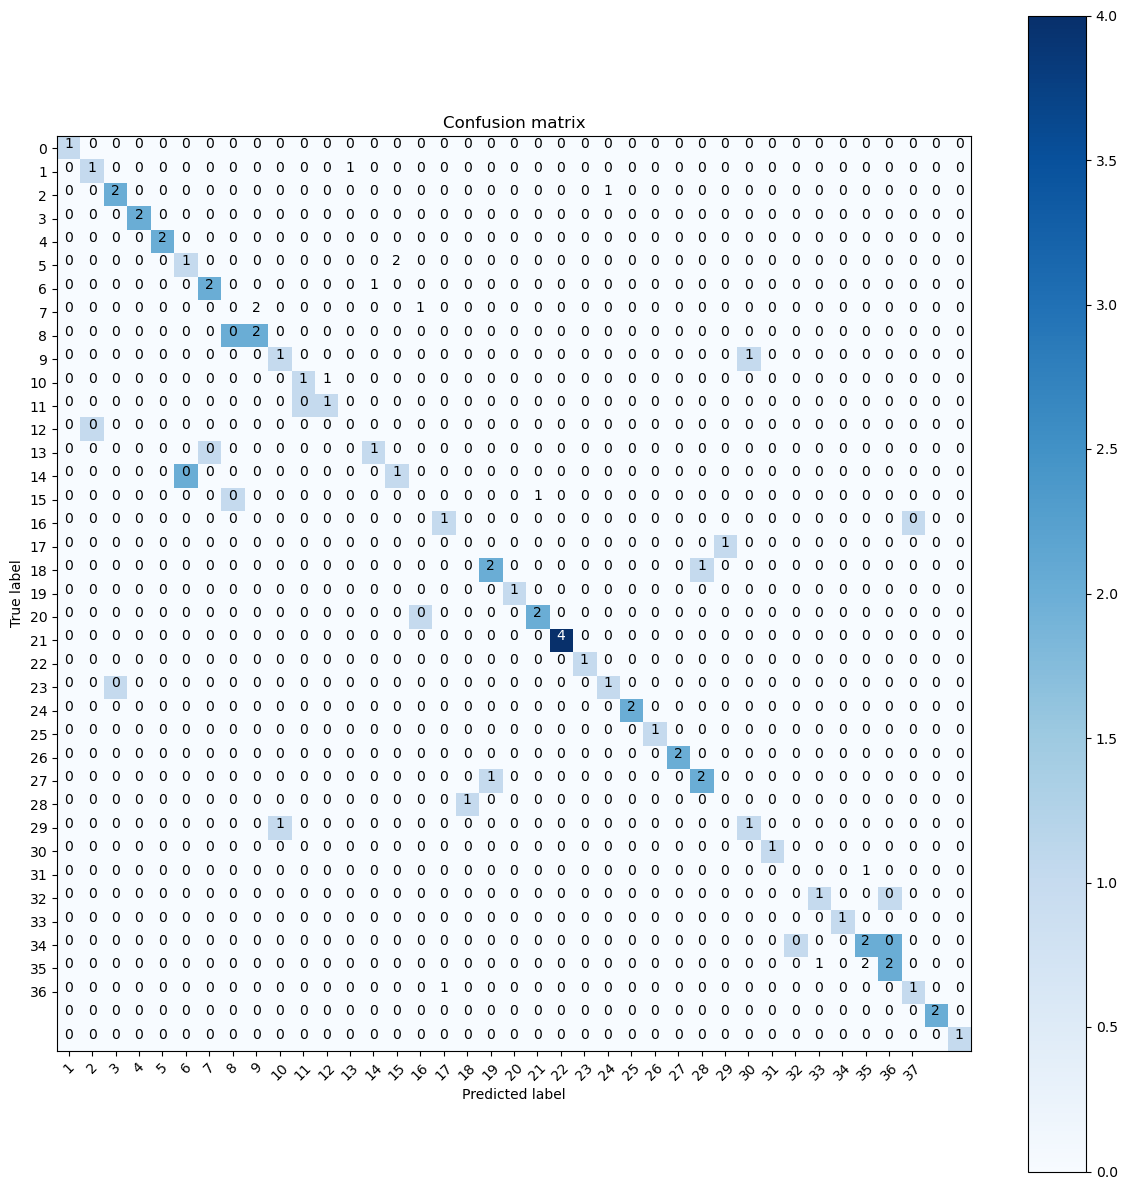

              precision    recall  f1-score   support

           2       1.00      1.00      1.00         1
           5       0.50      1.00      0.67         1
          17       0.67      1.00      0.80         2
          24       1.00      1.00      1.00         2
          25       1.00      1.00      1.00         2
          26       0.33      1.00      0.50         1
          36       0.67      1.00      0.80         2
          39       0.00      0.00      0.00         0
          40       1.00      0.50      0.67         4
          41       0.50      0.50      0.50         2
          45       0.50      1.00      0.67         1
          46       1.00      0.50      0.67         2
          57       0.00      0.00      0.00         1
          72       1.00      0.50      0.67         2
          73       1.00      0.33      0.50         3
          80       0.00      0.00      0.00         1
          87       1.00      0.50      0.67         2
          91       0.00    

In [55]:
summary.show_sample_metrics(1)

<Figure size 2500x2500 with 2 Axes>

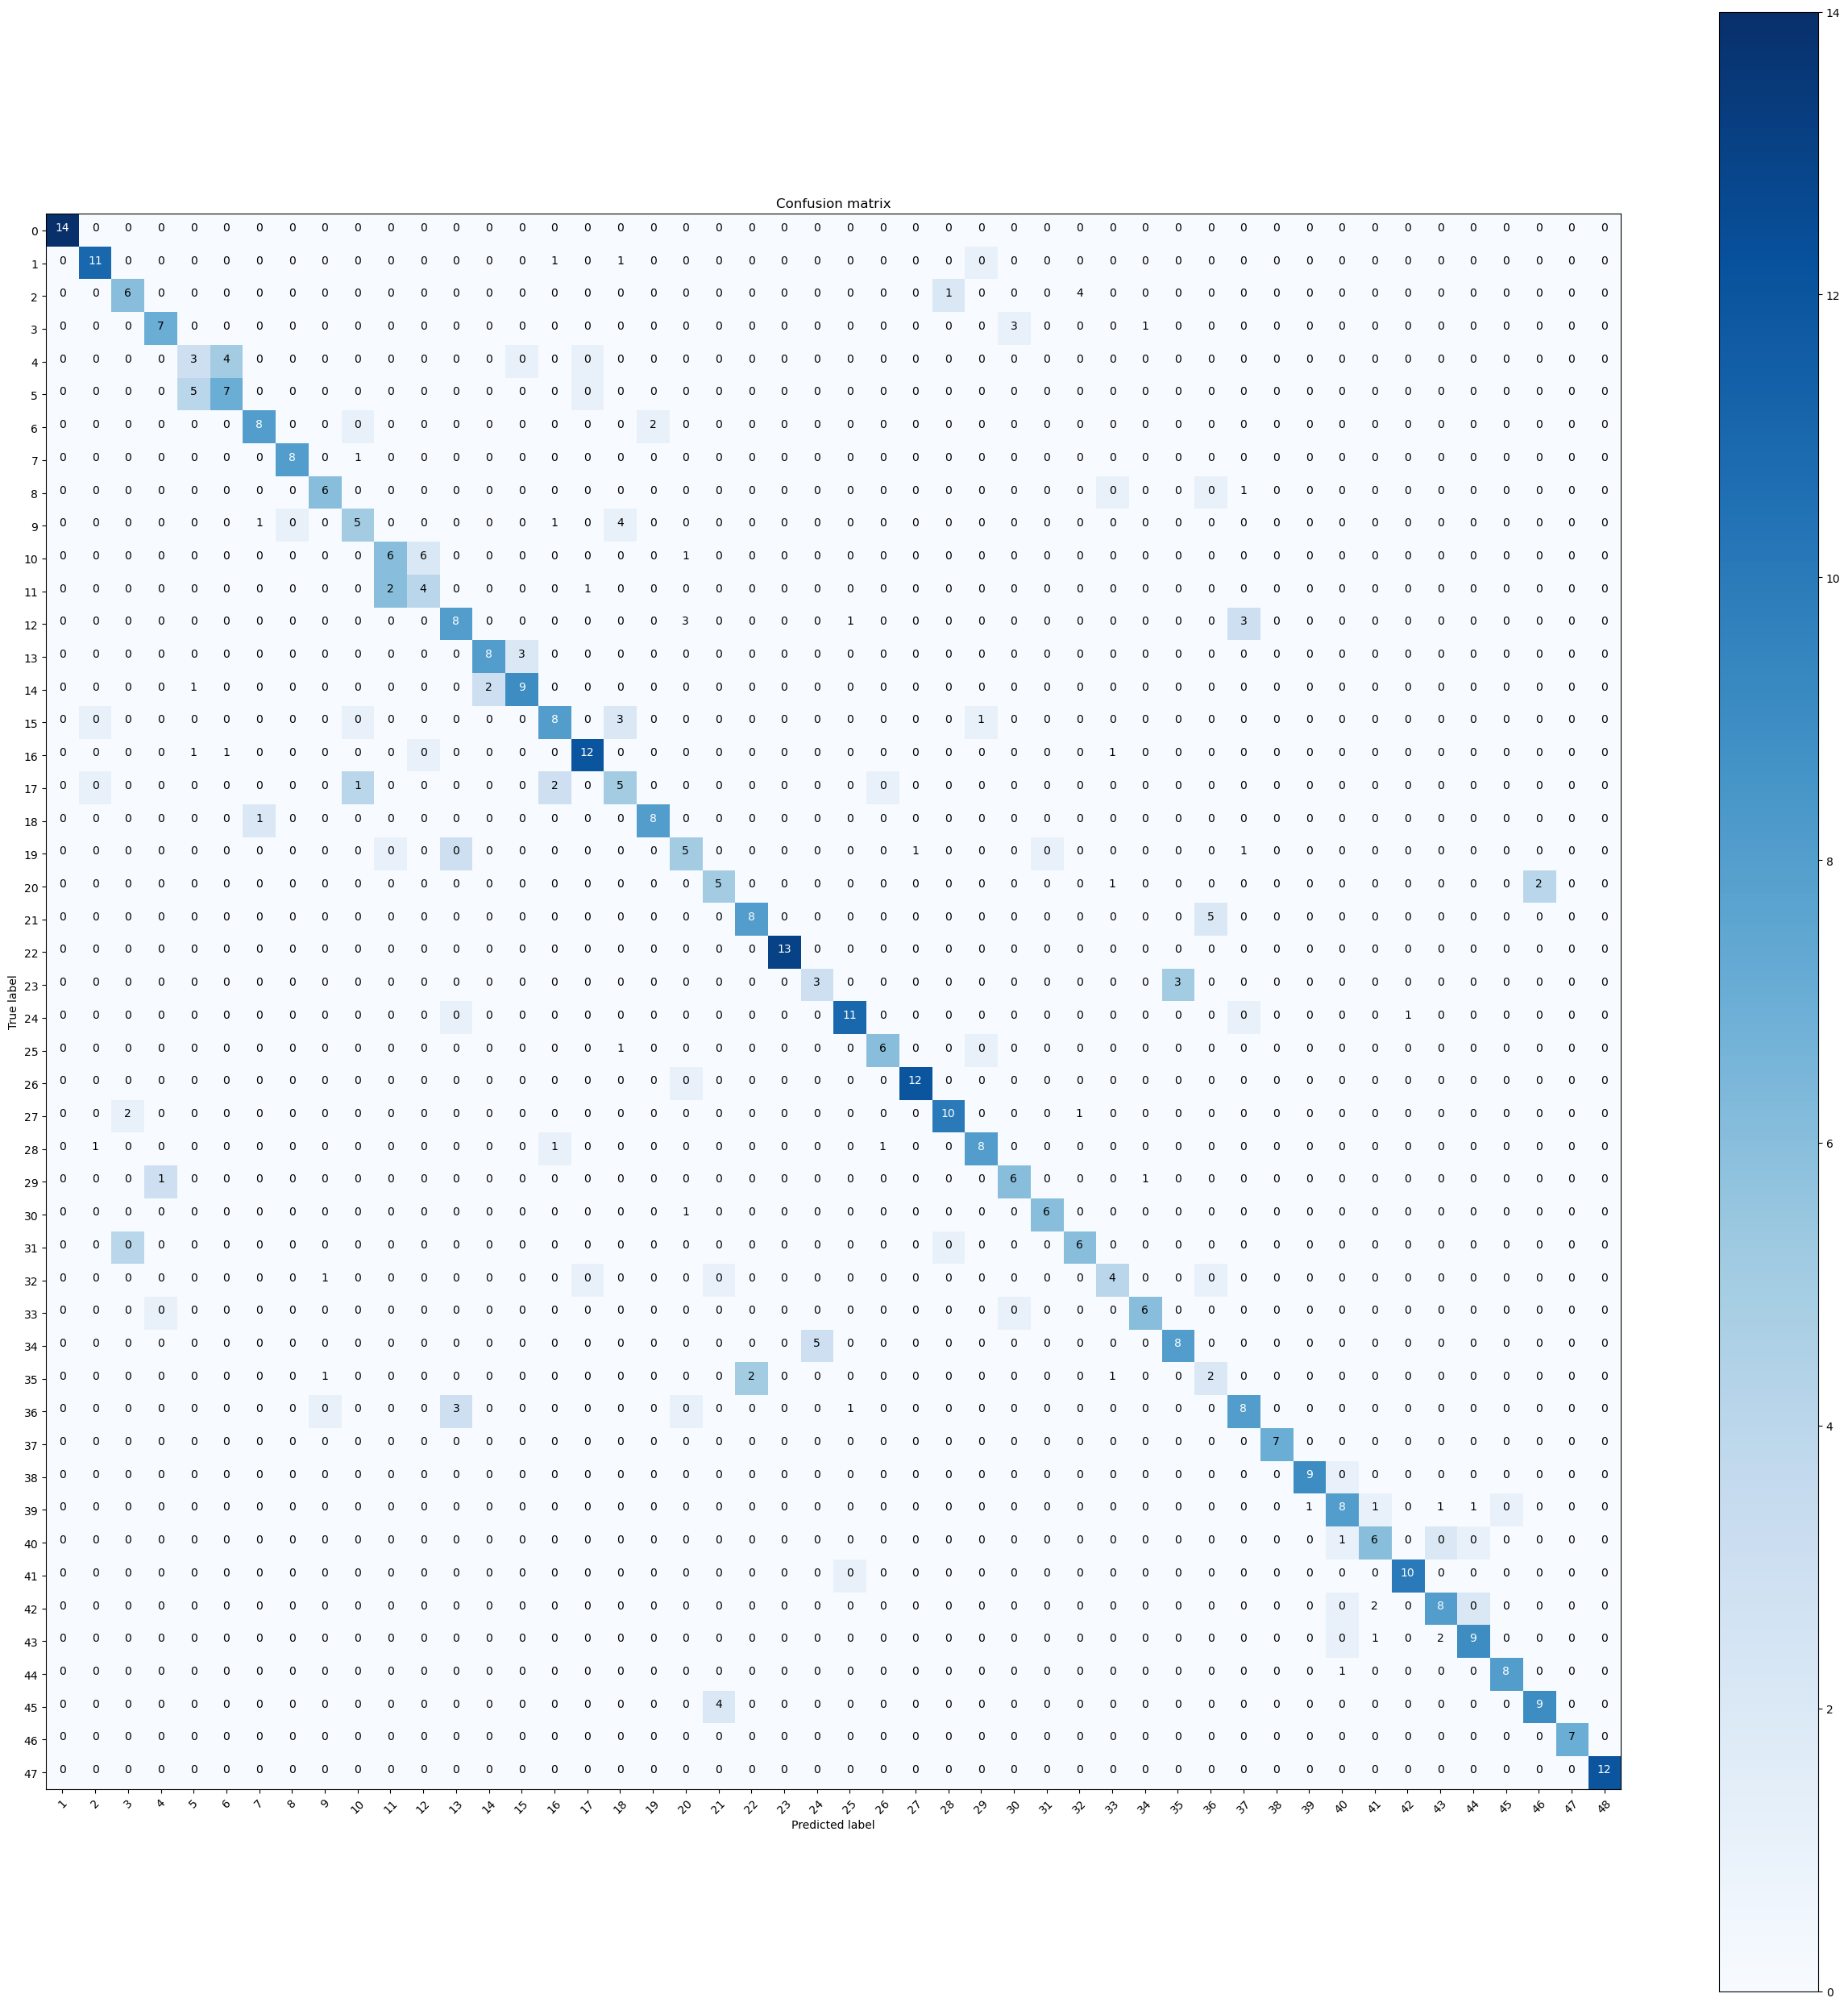

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        14
           5       0.85      0.92      0.88        12
           6       0.55      0.75      0.63         8
          17       0.64      0.88      0.74         8
          24       0.43      0.30      0.35        10
          25       0.58      0.58      0.58        12
          26       0.80      0.80      0.80        10
          27       0.89      1.00      0.94         8
          28       0.86      0.75      0.80         8
          36       0.45      0.71      0.56         7
          39       0.46      0.75      0.57         8
          40       0.57      0.40      0.47        10
          41       0.53      0.73      0.62        11
          45       0.73      0.80      0.76        10
          46       0.75      0.75      0.75        12
          57       0.67      0.62      0.64        13
          60       0.80      0.92      0.86        13
          72       0.62    

In [56]:
summary.show_metrics()